# Calculating out-of-sample Markov Model Performance
We will build on our previous discussions about Markov models during this project. We will evaluate the out-of-sample performance of the daily growth rate model we developed in the `HMM-WithJumps-Simulation-Notebook`. We anticipate that the out-of-sample performance will be inferior to the in-sample training data. Toward this hypothesis, we will examine various model performance metrics and assess the extent of the performance degradation.

### objectives
* __Prerequisites__: We begin by loading the daily growth rate Markov model file we saved. Using this data, we'll set various variables and constants that are used later.
* __Task 1__: Compute the encoded out-of-sample model prediction. Starting from the stationary distribution $\bar\pi$, generate a population of encoded `SPY` growth rate samples
* __Task 2__: Decode the out-of-sample model prediction. This will take the samples from Task 1 and transform them from discrete internal state variables to floating point values for the daily excess growth rate.
* __Task 3__: How good is the out-of-sample model prediction? Finally, we'll compare the properties of the out-of-sample prediction with the observed out-of-sample `SPY` growth rate sequence.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [1]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered an out-of-sample daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-02-2024` until `02-07-2025` (277 trading days), along with data for a few exchange-traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data; store the cleaned data in the `dataset` variable. We then calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in the `dataset.` Finally, you'll select a firm by changing the value in the `ticker` variable. We store the computed excess return for the `ticker` in the `Rᵢ` variable.
* Load the previous HMM model codes that we saved during model training.

Let's start by setting some constant values.

In [2]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 100; # number of potential futures should we look at
ticker = "SPY"; # This is the ticker we want to explore

#### Out-of-sample Dataset
Next, load and clean the historical out-of-sample dataset. We load the `out_of_sample_dataset` by calling the `MyOutOfSamplePortfolioDataSet()` function:

In [3]:
out_of_sample_dataset = MyOutOfSamplePortfolioDataSet() |> x->x["test_dataset"]

Dict{String, DataFrame} with 424 entries:
  "EMR"  => 277×8 DataFrame…
  "CTAS" => 277×8 DataFrame…
  "HSIC" => 277×8 DataFrame…
  "KIM"  => 277×8 DataFrame…
  "PLD"  => 277×8 DataFrame…
  "IEX"  => 277×8 DataFrame…
  "BAC"  => 277×8 DataFrame…
  "CBOE" => 277×8 DataFrame…
  "EXR"  => 277×8 DataFrame…
  "NCLH" => 277×8 DataFrame…
  "CVS"  => 277×8 DataFrame…
  "DRI"  => 277×8 DataFrame…
  "DTE"  => 277×8 DataFrame…
  "ZION" => 277×8 DataFrame…
  "AVY"  => 277×8 DataFrame…
  "EW"   => 277×8 DataFrame…
  "EA"   => 277×8 DataFrame…
  "NWSA" => 277×8 DataFrame…
  "CAG"  => 277×8 DataFrame…
  "GILD" => 277×8 DataFrame…
  "FCX"  => 277×8 DataFrame…
  "GPC"  => 277×8 DataFrame…
  "UNP"  => 277×8 DataFrame…
  "CDW"  => 277×8 DataFrame…
  "SBUX" => 277×8 DataFrame…
  ⋮      => ⋮

In [4]:
out_of_sample_dataset["SPY"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,1.22985e8,472.51,472.16,472.65,473.67,470.49,2024-01-02T05:00:00,657584
2,1.03578e8,469.898,470.43,468.79,471.19,468.17,2024-01-03T05:00:00,656569
3,8.42023e7,468.554,468.3,467.28,470.96,467.05,2024-01-04T05:00:00,536469
4,8.61189e7,468.078,467.49,467.92,470.44,466.43,2024-01-05T05:00:00,562579
5,7.46671e7,471.969,468.43,474.6,474.75,468.3,2024-01-08T05:00:00,523805
6,6.56134e7,473.537,471.87,473.88,474.93,471.35,2024-01-09T05:00:00,448471
7,6.73006e7,475.682,474.16,476.56,477.448,473.87,2024-01-10T05:00:00,470044
8,7.791e7,475.315,477.59,476.35,478.12,472.26,2024-01-11T05:00:00,576611
9,5.80264e7,476.587,477.84,476.68,478.6,475.23,2024-01-12T05:00:00,470855


Lastly, let's get a sorted list of firms that we have in cleaned up `dataset` and save it in the `list_of_all_tickers::Array{String,1}` array

In [29]:
list_of_all_tickers = keys(out_of_sample_dataset) |> collect |> x->sort(x)

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

We compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). 
* The result is stored in the `all_firms_return_matrix::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [31]:
all_firms_excess_return_matrix = log_growth_matrix(out_of_sample_dataset, list_of_all_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

Extract the growth rate for your `ticker::String` of interest, and save this in the `Rᵢ::Array{Float64,1}` array. This is the observed _out-of-sample_ data.

In [55]:
Rᵢ = findfirst(x->x==ticker, list_of_all_tickers) |> i-> all_firms_excess_return_matrix[:,i]

276-element Vector{Float64}:
 -1.438680853125062
 -0.7641165966073945
 -0.29823482336757323
  2.0440997421164475
  0.7935602440930389
  1.09692386730893
 -0.23633399955474685
  0.6314338044144273
 -0.9287479190850549
 -1.71405525853851
  1.5408010135322212
  2.7140803480999054
  1.8992332333663595
  ⋮
  0.5683416581528059
  0.19269345325072024
 -4.155060058267535
  1.6401100566972553
 -0.2896337656422111
  0.7789676586300984
  0.16511519707688865
 -3.286479044586992
  1.5551238819105009
  0.6941897666530115
  1.192737015246667
 -1.0456098361015878

#### Load the HMM model
We saved the Markov model, and the Jump Markov model along with some other data when we explored the in-sample performance of the approach. Let's load that file here to grab those model instances. We start by specifying the `path_to_save_file::String` variable:

In [34]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-$(ticker)-daily-aggregate.jld2");

Then we load the [`HDF5` binary saved file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) holding our data from the previous example located using the [load(...) function exported by the JLD2.jl package to read the binary save file](https://github.com/JuliaIO/JLD2.jl.git). This will load up the saved data into the `saved_state_dictionary::Dict{String, Any}` variable

In [35]:
saved_state_dict = load(path_to_save_file)

Dict{String, Any} with 6 entries:
  "in_sample_decoded_archi… => [0.469297 2.11123 … 0.848217 0.00995903; 1.0218 …
  "insampledataset"         => [-0.62664, 0.840526, 0.163892, -0.0102337, 0.258…
  "stationary"              => Categorical{Float64, Vector{Float64}}(…
  "jump_model"              => MyHiddenMarkovModelWithJumps([1, 2, 3, 4, 5, 6, …
  "decode"                  => Dict{Int64, Normal}(5=>Normal{Float64}(μ=-3.1106…
  "encoded_archive_with_ju… => [49 70 … 56 37; 58 43 … 14 53; … ; 53 22 … 52 55…

## Task 1: Compute the encoded out-of-sample model prediction
In this task, you will sample either the `model::MyHiddenMarkovModel` or the `model::MyHiddenMarkovModelWithJumps` instance to generate a family of _encoded_ state sequences, i.e., a series of discrete state values $s_{j}\in\mathcal{S}$ where each sample trajectory starts from a draw from the stationary distribution $\bar\pi$. 

We computed the stationary distribution $\bar\pi$ in the worked example. Here we access the saved value from the `saved_state_dict::Dict{String, Any}` dictionary using the `stationary::String` key. We save the stationary distribution in the `π̄::Categorical{Float64, Vector{Float64}}` variable:

In [36]:
saved_state_dict["insampledataset"]

2514-element Vector{Float64}:
 -0.6266399670984476
  0.8405262386945092
  0.16389199696256232
 -0.010233691939436122
  0.25823420862761537
 -1.378088774125505
  0.32241271641711466
  2.0009590819913137
 -0.322149763808254
 -0.43598073791618397
 -0.07579593758943923
  0.3992882778085264
 -1.99925091651247
  ⋮
  2.473645326630101
  2.1846892155556126
 -1.3071088568715163
  1.300092524780104
  1.0882119750549104
 -1.2691490306414208
 -0.2817789495022863
  1.3302918641120702
  0.6544841382666371
  0.307245721134233
  0.48928417021417847
 -0.7889919650587696

In [37]:
π̄ = saved_state_dict["stationary"];

Let's now generate the `encoded_archive::Array{Int64,2}` array, which holds `number_of_paths` discrete state trajectories each of length `number_of_steps` by using some fantastic _syntactic-sugar in Julia_:
* Internally, we've created a function `(m::MyHiddenMarkovModelWithJumps)(start::Int64, steps::Int64) = _simulate(m, start, steps)` which provides a short-cut syntax to sampling the `model::MyHiddenMarkovModelWithJumps` instance, where the sampling logic is encoded in the private `_simulate(m, start, steps)` function. We have a similar function for the `m::MyHiddenMarkovModel` type.

After declaring how many sample paths we want (specified in the `number_of_paths::Int64` variable), how many steps we are going to take (specified in the `number_of_steps::Int64` variable), and initializing the `encoded_archive::Array{Int64,2}` array which will store the model samples, we populate the sample array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):
* The outer loop iterates over the sample paths, the `i` index, where we generate an initial state for each sample path by drawing a sample from the $\bar\pi$ distribution. We save the initial state in the `start_state::Int64` variable.
* The inner loop iterates over the time steps in each sample path, the `j` index, where we generate a `number_of_steps`$\times$ `1` array of discrete state values $s\in\mathcal{S}$ in the `tmp::Array{Int64,1}` array. We then add the values of the `tmp` array to the `encoded_archive` array, where the time steps are on the rows and the sample paths are on the columns.

In [38]:
encoded_archive = let
    
    model = saved_state_dict["jump_model"]; # grab which ever version of the model you want
    number_of_steps = length(Rᵢ); # how much data do we have?
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);
        tmp = model(start_state, number_of_steps) # generates state sequence of length number_of_steps
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j]
        end
    end
    encoded_archive
end

276×100 Matrix{Int64}:
 78  32  58   3  76  30  66  25  62  …  38  62  15  48  65  35  62  70  78
 42  51  76  54  12  28  41  53  50     48  75  56  65  74  32  49  55  64
 32  79  76  30  60   6  20  40  45     25   1  75  30  62  27  16  52  10
 39  80  57  31  21   5  22  56  47     67  52  44  27  48  15  28  71  78
 20  80  29  46  68  76  78  35  72     24  36  31  15  59   3  64  58  76
 34  32  55  27  41   7  59  28   8  …  62  24  40   3  38  65  24  59  75
  3  60  11  15  40  35  28  35   2     17  56  77  61  50  27  54  22  75
  7  17  55  65  41  42   6  42  80     38  28  20  29  58  66  24  30  73
 74  30  11  57  64  47  70  16  79     30  56  37  48  62  27  26  47  73
 49  60  78  67  77  31  14   6  78     26  65  80  64  34   9  23  74  38
 22  48  39  38  66  66  47  17  56  …  61  72   4  78  59  54  61  65  62
 46  37  37  19  31  56  24  26  57     29  79   5  56  69  13  67  39  59
 54  61  37  46  33  61  26  29  68      3  50   7   9  55   2  10  25  57
  

## Task 2: Decode the out-of-sample model prediction
Now that we have populated the `encoded_archive::Array{Int64,2}` array, which holds the hidden discrete states, we need to convert the discrete states back into floating point excess growth rate values. We do this using a _decoding model_ which transforms the encoded values into growth rate values. We generated (and persisted) the _decode model_ in the worked example. 
* Load the _decode model_ from the `saved_state_dict::Dict{String, Any}` dictionary using the `decode::String` key. We save the _decode model_ in the `decode_distribution_model::Dict{Int64, Normal}` dictionary.

In [117]:
decode_distribution_model = saved_state_dict["decode"];

The `decode_distribution_model::Dict{Int64, Normal}` dictionary holds a [Normal distribution model](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) for each state $s\in\mathcal{S}$. We sample these distributions to generate a value of the excess growth rate that corresponds to a particular discrete state `s.` Thus, to decode the encoded sample array, we iterate through the `encoded_archive` array and sample the _decode model_ that is associated with $s\in\mathcal{S}$, and then save that value in the `out_of_sample_decoded_archive::Array{Float64,2}` array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):
* The outer loop iterates over the sample paths, the `i` index, while the inner loop, the `j` index, iterates over the time steps. Inside the inner loop, we select a state `s,` access the corresponding _Normal decode model_ for state `s,` (the `j,i` element of the `encoded_archive`) and sample that model [using a `rand(...)` method exported by the  Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Base.rand-Tuple{AbstractRNG,%20UnivariateDistribution}) in combination with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

The `out_of_sample_decoded_archive::Array{Float64,2}` holds values for the excess growth rate for each time step and sample path.

In [40]:
out_of_sample_decoded_archive = let

    number_of_steps = length(Rᵢ); # average number of trading days per year
    
    out_of_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive[j,i];
            out_of_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
        end
    end
    out_of_sample_decoded_archive # actual excess growth value (not internal state variables)
end

276×100 Matrix{Float64}:
  4.17023    -0.220014     1.00521      …   1.28521     2.10514     4.40116
  0.168825    0.57337      3.29192          0.490774    0.802454    1.43816
 -0.213817    5.24684      3.40518         -1.19606     0.632314   -1.95048
  0.0781647   7.37075      0.913002        -0.439013    2.27986     4.32804
 -0.923611    5.84765     -0.36784          1.42533     1.01339     3.53624
 -0.102056   -0.238116     0.78881      …  -0.668023    1.04777     3.10566
 -3.98447     1.11421     -1.84601          0.75661    -0.78298     3.09646
 -2.58548    -1.16405      0.809141        -0.66654    -0.31192     2.64031
  3.0177     -0.32193     -1.88341         -0.515451    0.392755    2.45636
  0.51137     1.15688      4.46123         -0.683399    2.87069     0.0327941
 -0.800298    0.443968     0.0689366    …   1.2119      1.53461     1.26354
  0.343277   -0.00893378   0.0207132        1.7595      0.0720873   1.03289
  0.747305    1.19839     -0.000654327     -2.00387    -0.588

## Task 3: How good is the out-of-sample model prediction?
Now that we have populated the `out_of_sample_decoded_archive::Array{Float64,2}` array with excess growth rate values, we can test how well the out-of-sample simulations replicate the properties of the out-of-sample observations. 
* First, let's plot the simulated distributions versus the observed out-of-sample excess growth distributions and examine them to get a qualitative idea of how close the simulations are to the observed values. 
* Then, we'll [use the `ApproximateTwoSampleKSTest` method exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) to compute the fraction of trials that appear to be drawn from the same distribution.

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the out-of-sample data.
* __Summary__: The simulated out-of-sample excess growth rate distributions (blue lines) and the observed distribution (red line) are qualitatively similar; however, the simulated distributions appear to be more heavily tailed, with more density for near-zero growth rates and broader tails. 

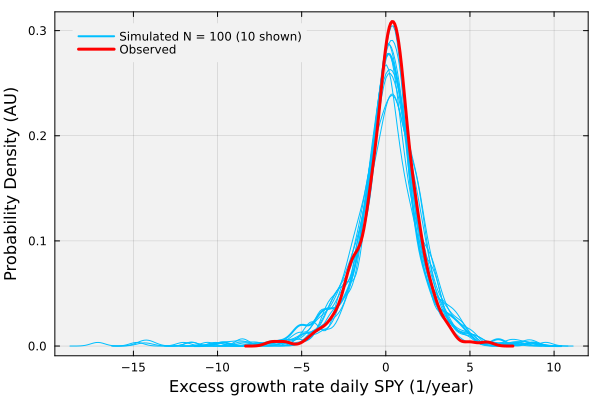

In [41]:
let
    q = plot(); 
    skip = 10;
    N = 1:skip:number_of_paths |> collect |> length;
    density!(out_of_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated N = $(number_of_paths) ($(N) shown)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft)
    for i ∈ 2:skip:number_of_paths
        density!(out_of_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(Rᵢ, c=:red, lw=3, label="Observed")
    xlabel!("Excess growth rate daily $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()

    #savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-ExcessGrowthRate-Probability-Density-HMM-out-of-sample.svg"));
end

### Check: Mean and standard deviation of the out-of-sample data
The distributions above _look similar_ but let's dig deeper. For example, is the mean of out-of-sample predicted excess growth rate distribution (or the standard deviation) consistent with the observed data? Let's check if the simulated values bound the observed mean (and standard deviation) for the out-of-sample data.

#### Simulated mean and standard deviation
Compute the mean over the time dimension (rows) of the `out_of_sample_decoded_archive` array using [the Julia `mean(...)` function, where the `dim = 1` argument allows us to compute the mean over the rows](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean). 
* This will return `number_of_paths` values for the mean (a value for each sample path), so we compute the mean over the sample paths [using the `mean(...)` function again](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) in combination with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We save the simulated sample mean as the `μ̄::Float64` variable:

In [42]:
μ̄ = mean(out_of_sample_decoded_archive, dims=1) |> x -> mean(x); # average mean
println("Out-of-sample estimated simulated mean: μ̄ = $(μ̄)")

Out-of-sample estimated simulated mean: μ̄ = 0.06302563447369149


Similarly, we compute the expected standard deviation over time and then over the `number_of_paths` sample paths using [the `std(...)` function with the `dim = 1` argument](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.std) in combination with [the `mean(...)` function again](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) and the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We save the simulated sample standard deviation as the `σ̄::Float64` variable:

In [43]:
σ̄ = std(out_of_sample_decoded_archive, dims=1) |> x -> mean(x); # average standard deviation
println("Out-of-sample estimated simulated standard deviation: σ̄ = $(σ̄)")

Out-of-sample estimated simulated standard deviation: σ̄ = 2.1674939674711347


#### Comparison with observed values
Next, let's compute the observed mean and standard deviation values from the `out_of_sample_dataset` using the [Julia `mean(...)`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) and [`std(...)` functions exported by Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean). Save these values in the `μ::Float64` and `σ::Float64` variables:

In [44]:
μ = mean(Rᵢ, dims=1) |> first; # observed growth rate from data
σ = std(Rᵢ, dims=1) |> first; # observed standard deviation from data

__Test I__: Let's test whether the observed out-of-sample excess growth rate mean is contained in a $\pm$ `SEM` range around the mean computed over the simulations samples, i.e.., we test the condition: 
$$
\mu \in R_{\mu} \equiv \left[\bar{\mu}-\frac{\bar{\sigma}}{\sqrt{N}},\,\bar{\mu}+\frac{\bar{\sigma}}{\sqrt{N}}\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\mu\notin{R}_{\mu}$, i.e., the observed mean is not bounded by $\pm$`SEM`, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError), where `SEM` denotes the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

In [45]:
let
    R = (μ̄ - σ̄/√number_of_paths, μ̄ + σ̄/√number_of_paths);
    println("R = $(R) and μ = $(μ), μ̄ = $(μ̄)")
    @assert R[1] ≤ μ && μ ≤ R[2]
end

R = (-0.153723762273422, 0.27977503122080494) and μ = 0.1804235695871154, μ̄ = 0.06302563447369149


In [46]:
let
    ϵ = 100*abs(((μ - μ̄)/μ)); # percentage difference in std
    println("The percentage difference between the observed and simulated mean is: $(ϵ)%")
end

The percentage difference between the observed and simulated mean is: 65.06795945899945%


__Test II__: Next, test the simulated versus observed standard deviation of the excess growth, i.e., the volatility for the out-of-sample values. In this case, we test the conditions:
$$
\sigma\in R_{\sigma} \equiv \left[\sqrt\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{r}^2},\,\sqrt{\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{l}^2}}\,\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\sigma\notin{R}_{\sigma}$, i.e., the observed standard deviation is not bounded by $\pm\sqrt{(N-1)\cdot{\bar{\sigma}^{2}}/\chi_{\star}^{2}}$, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). 
* Where $\chi_{\star}^{2}$ denotes the $\star=\left\{l,r\right\}$ left (`l`) or right (`r`) tail of the [chi-squared distribution with $N − 1$ degrees of freedom](https://en.wikipedia.org/wiki/Chi-squared_distribution). We use [the `Chisq(...)` distribution model exported by Distributions.jl](https://github.com/JuliaStats/Distributions.jl) in combination with [the `quantile(...)` function also exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) to compute the $\chi_{\star}^{2}$ values:

In [47]:
α = 0.99;
ᾱ = (1 - α);
chi_d = Chisq(number_of_paths);
χₗ = quantile(chi_d,ᾱ);
χᵣ = quantile(chi_d,α);
println("For CI = $(100*α)%, the (χₗ,χᵣ) = ($(χₗ),$(χᵣ))")

For CI = 99.0%, the (χₗ,χᵣ) = (70.0648949253998,135.80672317102676)


Finally, check if $\sigma\in{R}_{\sigma}$ using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert):

In [48]:
let
    R = (sqrt(((number_of_paths - 1)*σ̄^2)/(χᵣ)), sqrt(((number_of_paths - 1)*σ̄^2)/(χₗ)));
    println("R = $(R) at CI = $(100*α)% and σ = $(σ), σ̄ = $(σ̄)")
    @assert R[1] ≤ σ && σ ≤ R[2]
end

R = (1.850609807903585, 2.576470992128551) at CI = 99.0% and σ = 1.665053790097313, σ̄ = 2.1674939674711347


LoadError: AssertionError: R[1] ≤ σ && σ ≤ R[2]

__What if we fail Test II__? Currently, the model simulation fails `Test II,` i.e., the uncertainty of the standard deviation computed by the Markov model does not include the standard deviation value calculated from the out-of-sample observations (the simulated range is biased high); the standard deviation values have a percentage difference of:

In [49]:
let
    ϵ = 100*abs(((σ - σ̄)/σ)); # percentage difference in std
    println("The percentage difference between the observed and simulated stdev is: $(ϵ)%")
end

The percentage difference between the observed and simulated stdev is: 30.17561236531925%


### Check: Are the predicted and observed out-of-sample distributions the same? 
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution.
#### Kolmogorov-Smirnov (K-S) Test

The Kolmogorov-Smirnov (K-S) test is a non-parametric method used to determine if two samples of data are drawn from the same underlying distribution. It works by quantifying the **maximum vertical distance** between the empirical cumulative distribution functions (ECDFs) of the two samples.

The hypotheses are:
- **H0 (null hypothesis):** The two samples are drawn from the same distribution.
- **H1 (alternative hypothesis):** The two samples are drawn from different distributions.

The K-S test is generally most sensitive to differences in the **center (i.e., around the median)** of the distributions.

To check this hypothesis, we will use [the `ApproximateTwoSampleKSTest` function from the `HypothesisTests.jl` package](https://github.com/JuliaStats/HypothesisTests.jl). Let's run it on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests the samples are from the same distribution):

In [50]:
pvalue_cutoff = 0.05; # if larger than this, we reject the H0
pass_counter = 0;
for i ∈ 1:number_of_paths
    test_value = ApproximateTwoSampleKSTest(Rᵢ, out_of_sample_decoded_archive[:,i]) |> pvalue   
    if (test_value > pvalue_cutoff)
        pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
    end
end
println("Pass percentage: $((pass_counter/number_of_paths)*100)%")

Pass percentage: 82.0%


In [51]:
ApproximateTwoSampleKSTest(Rᵢ, out_of_sample_decoded_archive[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0615942

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6717

Details:
    number of observations:   [276,276]
    KS-statistic:              0.7235680511449364


#### Anderson-Darling Test
The Anderson-Darling test is another method for testing whether two samples of data come from the same distribution. A key advantage of the A-D test over the K-S test is its higher sensitivity to differences in the tails of the distributions. This is particularly relevant for financial time series, where capturing tail risk and extreme events is critical.
Let's run it on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests the samples are from the same distribution):

In [56]:
let
    pvalue_cutoff = 0.05; # cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = KSampleADTest(Rᵢ, out_of_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 80.0%


In [75]:
KSampleADTest(Rᵢ, out_of_sample_decoded_archive[:,rand(1:number_of_paths)])

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           0.0044

Details:
    number of samples:        2
    number of observations:   552
    SD of A²k:                0.7587507844451381
    A²k statistic:            4.610498686214369
    standardized statistic:   4.758477698121481
    modified test:            true
    p-value calculation:      asymptotic


### Model Validation via Correlation Distance

This cell performs a key validation step for our simulation model. It quantifies how "realistic" our thousands of simulated `out-of-sample` paths are by comparing each one directly to the single `observed` (real) path.

**Here is the process:**

1.  **Iterate:** It loops through every single simulated path (`R̂`) in our `out_of_sample_decoded_archive`.
2.  **Compare:** For each simulation, it calculates the **Correlation Distance** (`corr_dist`) against the real, observed path (`Rᵢ`).
    * This distance metric is defined as $1 - \rho$ (where $\rho$ is the Pearson correlation).
    * A distance of **0** means perfect correlation (identical movement).
    * A distance of **1** means zero correlation (totally unrelated).
    * A distance of **2** means perfect anti-correlation (opposite movement).
3.  **Plot:** It plots the probability density of all these thousands of distance scores.

The resulting plot shows us the **distribution of similarity** between our model's simulations and reality. The vertical red line highlights the **mean distance**, giving us a single number to summarize our model's performance.

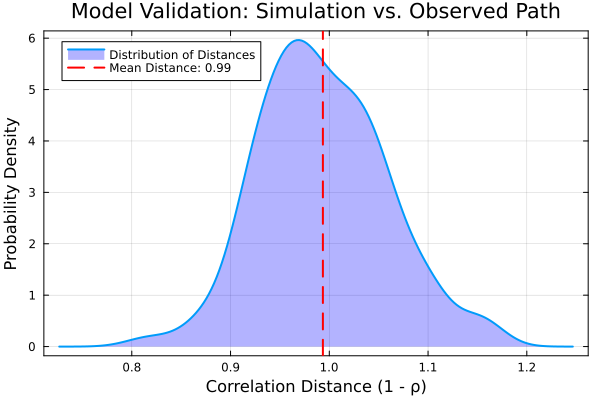

In [102]:
let
    # 1. Calculate all the distances (same as before)
    distance_array = Array{Float64, 1 }();
    for i ∈ 1:number_of_paths
        R̂ = out_of_sample_decoded_archive[:,i]; # simulated return
        r = corr_dist(R̂,Rᵢ);
        push!(distance_array,r);
    end

    # 2. Calculate the mean distance for annotation
    mean_dist = mean(distance_array)

    # 3. Create the density plot
    density(distance_array,
        label = "Distribution of Distances",
        linewidth = 2,
        title = "Model Validation: Simulation vs. Observed Path",
        xlabel = "Correlation Distance (1 - ρ)",
        ylabel = "Probability Density",
        legend = :topleft,
        fill = (0, 0.3, :blue),
        framestyle = :box
    )

    # 4. Add a vertical line at the mean distance
    vline!([mean_dist],
        label = "Mean Distance: $(round(mean_dist, digits=2))",
        color = :red,
        linestyle = :dash,
        linewidth = 2
    )
    
end

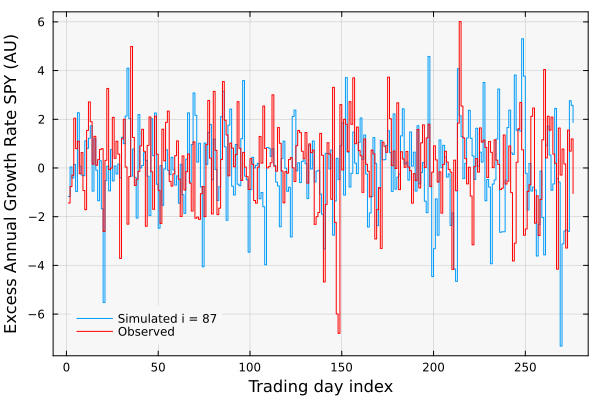

In [188]:
let
    index_to_plot = rand(1:number_of_paths);
    number_of_steps = length(out_of_sample_dataset); # average number of trading days per year

    plot(out_of_sample_decoded_archive[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray97", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(Rᵢ, linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fintsize=18)
    ylabel!("Excess Annual Growth Rate $(ticker) (AU)", fontsize=18)

    #savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-out-of-sample-ExcessGrowthRate-Trajectory-Daily-HMM.svg"))
end

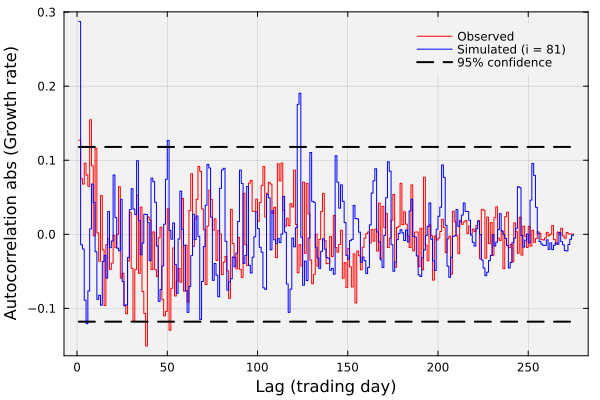

In [189]:
let
    # generate a random index -
    random_index = rand(1:number_of_paths);
    number_of_steps = length(Rᵢ);

    plot(autocor(abs.(Rᵢ), (1:(number_of_steps-1) |> collect)), label="Observed", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)
    plot!(autocor(abs.(out_of_sample_decoded_archive[:,random_index]), ((1:(number_of_steps - 1)) |> collect)), c=:blue,
        label="Simulated (i = $(random_index))", linetype=:steppost)
    
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation abs (Growth rate)", fontsize=18)

    #savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-out-of-sample-ExcessGrowthRate-VC-HMM.svg"))
end

### Disclaimer: For Educational and Research Purposes Only

The content in this repository is provided strictly for informational, educational, and research purposes. It is not intended as, and should not be construed as, financial advice, an offer, or a solicitation to buy or sell any securities or derivative products.

#### Risk Warning

Trading and investing involve substantial risk. The models and strategies demonstrated here are for illustrative purposes only. Past performance, whether actual or backtested, is not a guarantee of future results.

You are solely responsible for any investment or trading decisions you make. Always conduct your own research and carefully assess your financial situation, investment objectives, and risk tolerance before trading or investing. You should only risk capital that you can afford to lose and that is not essential for your living expenses.